### Imports

In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
from biotuner.dictionaries import *
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Deriving spectral chords from biosignals

This notebook is intended to demonstrate the use of the biotuner (https://github.com/antoineBellemare/biotuner/)

The biotuner toolbox allows to extract harmonic information from biological time series, which in turn informs the computation of musical structures. More specifically, we will show how to derive spectral chords based on the harmonicity of spectral peaks.

### Spectral chords from spectral centroid

The first step to compute spectral chords is to decompose the signal into multiple components, so we will be able to have multiple frequencies associated with a single timepoint. To do so, we use the Empirical Mode Decomposition, which decomposes the signal into a set of Intrinsic Mode Functions (IMF). Hence, you can compute spectral chords based on the timepoint consonance levels between each IMF. For each timepoint, the consonance is compute between the spectral centroid of each IMF.

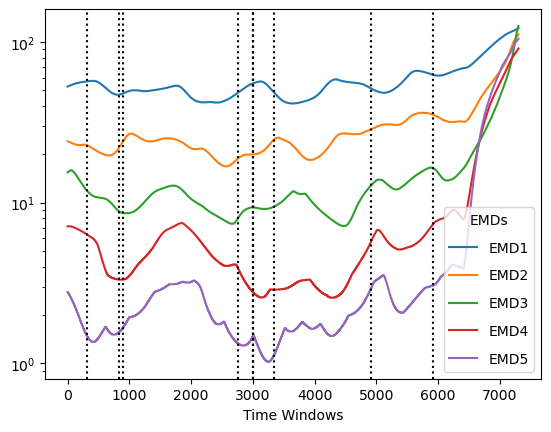

<Figure size 640x480 with 0 Axes>

In [2]:
# Load dataset
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

# Define frequency bands for peaks_function = 'fixed'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] 

# Select a single time series
data_ = data[10][0:7500]
start = time.time()

# Initialize biotuner object
biotuning = compute_biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.5, n_harm = 10)

# Extract spectral peaks
biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=False, min_harms=2)

# Compute spectromorphological metric on each IMF
biotuning.compute_spectromorph(comp_chords=True, method='SpectralCentroid', min_notes=4,
                               cons_limit=0.5, cons_chord_method='cons', 
                               window=1000, overlap=1, graph=True)



In [3]:
# Instantaneous frequencies of IMFs at moment in time when threshold of consonance is reached
biotuning.spectro_chords 

[[6.33, 11.84, 1.48, 56.96],
 [47.11, 22.08, 1.57, 8.83],
 [23.9, 47.8, 3.32, 1.66],
 [7.92, 3.96, 1.34, 48.24],
 [55.38, 19.98, 2.77, 1.48],
 [55.4, 19.98, 2.77, 1.48],
 [55.42, 19.98, 2.77, 1.48],
 [24.64, 2.87, 1.12, 48.79],
 [5.73, 28.64, 51.45, 2.94],
 [7.36, 62.56, 3.07, 35.3]]

### Spectral chords from instantaneous frequencies

You can also compute timepoint consonance between the instantaneous frequencies using the Hilbert-Huang transform. To do so, we need to initialize the biotuner object with a peaks function 'HH1D_max', which means that Hilbert-Huang transform will be computed on each IMF, leading to estimations of instantaneous frequencies (IF).

In [4]:
# Choose a time series
data_HH = data[46, 2000:6000]

# Initialize biotuner object with Hilbert-Huang method
bt_HH_chords = compute_biotuner(sf = 1000, peaks_function = 'HH1D_max', precision = 0.5, n_harm = 20,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

# Extract spectral peaks
bt_HH_chords.peaks_extraction(data_HH, ratios_extension = True, max_freq = 60, n_peaks=5,
                          graph=False, min_harms=2, verbose=False)
# Look at the shape of instantaneous frequencies (n points, nIMFs)
bt_HH_chords.IF.shape

(4000, 5)

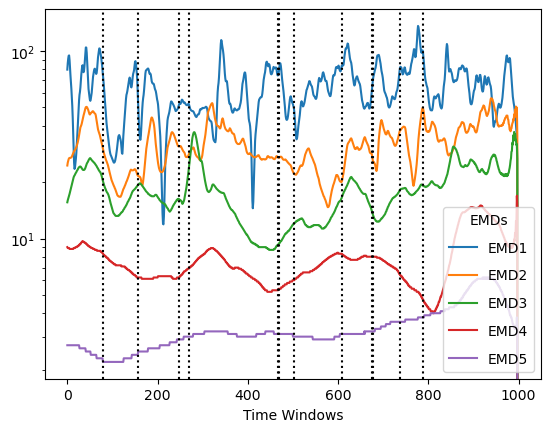

[[69.7, 19.8, 2.2, 8.2],
 [6.2, 21.7, 19.2, 2.4],
 [31.0, 6.2, 52.2, 2.9],
 [7.0, 28.5, 3.0, 24.5],
 [5.3, 3.1, 74.2, 9.3],
 [5.4, 27.0, 9.3, 3.1],
 [6.0, 12.0, 3.0, 49.5],
 [20.5, 84.0, 8.2, 16.8],
 [14.2, 28.4, 3.2, 8.0],
 [13.2, 3.2, 8.0, 72.6],
 [6.5, 3.6, 18.0, 78.0],
 [4.8, 100.7, 3.8, 19.2]]

In [5]:
from biotuner.metrics import timepoint_consonance
# Format IF
data_IF = np.moveaxis(bt_HH_chords.IF[3000:4000, :], 0, 1)

# Compute spectral chords
chords, positions = timepoint_consonance(np.round(data_IF, 1), method='cons', limit=0.5, min_notes=4,
                                         graph=True)
chords

In [6]:
# Transform the set of frequencies to set of integer ratios
chords_ratios2, chords_bounded2 = chords_to_ratios(chords, harm_limit=1, spread=True)
chords_ratios2

[[11, 12, 20, 22],
 [7, 12, 16, 24],
 [8, 10, 16, 29],
 [3, 5, 6, 10],
 [23, 23, 26, 31],
 [17, 23, 27, 31],
 [1, 2, 2, 2],
 [13, 26, 42, 82],
 [9, 9, 10, 16],
 [11, 16, 20, 32],
 [6, 11, 16, 18],
 [8, 12, 12, 19]]

In [7]:
# Rescale the set of integer ratios within one octave,
# such as the highest value is less than two time the first value
chords_ratios, chords_bounded = chords_to_ratios(chords, harm_limit=2, spread=False)
chords_ratios

[[22, 25, 41, 44],
 [24, 27, 31, 48],
 [29, 31, 33, 39],
 [30, 31, 35, 36],
 [31, 46, 46, 53],
 [31, 34, 46, 54],
 [30, 31, 60, 60],
 [82, 84, 102, 105],
 [8, 9, 9, 10],
 [32, 33, 40, 45],
 [36, 45, 49, 65],
 [38, 48, 48, 63]]

In [16]:
from biotuner.biotuner_utils import *
def listen_chords(chords, mult=10, length=500):
    """_summary_

    Parameters
    ----------
    chords : _type_
        _description_
    mult : int, optional
        _description_, by default 10
    length : int, optional
        _description_, by default 500
    """    
    print("Chords:", chords)

    for c in chords:
        c = [i * mult for i in c]
        chord = make_chord(c[0], c[1:], waveform=sine_wave)
        sound = pygame.sndarray.make_sound(chord)
        sound.play(loops=0, maxtime=0, fade_ms=0)
        pygame.time.wait(int(sound.get_length() * length))
        

### Listening to spectral chords

In [20]:
listen_chords(chords_bounded[:], 300, 500)

Chords: [[1.0, 1.1363636363636365, 1.8636363636363635, 2.0], [1.0, 1.125, 1.2916666666666667, 2.0], [1.0, 1.0689655172413792, 1.1379310344827587, 1.3448275862068966], [1.0, 1.0333333333333334, 1.1666666666666667, 1.2], [1.0, 1.4838709677419355, 1.4838709677419355, 1.7096774193548387], [1.0, 1.096774193548387, 1.4838709677419355, 1.7419354838709677], [1.0, 1.0333333333333334, 2.0, 2.0], [1.0, 1.024390243902439, 1.2439024390243902, 1.2804878048780488], [1.0, 1.125, 1.125, 1.25], [1.0, 1.03125, 1.25, 1.40625], [1.0, 1.25, 1.3611111111111112, 1.8055555555555556], [1.0, 1.263157894736842, 1.263157894736842, 1.6578947368421053]]


ValueError: Array must be 2-dimensional for stereo mixer

In [18]:
listen_chords(chords_bounded2[:], 300, 500)

Chords: [[1.0, 1.0909090909090908, 1.8181818181818181, 2.0], [1.0, 1.7142857142857142, 2.2857142857142856, 3.4285714285714284], [1.0, 1.25, 2.0, 3.625], [1.0, 1.6666666666666667, 2.0, 3.3333333333333335], [1.0, 1.0, 1.1304347826086956, 1.3478260869565217], [1.0, 1.3529411764705883, 1.588235294117647, 1.8235294117647058], [1.0, 2.0, 2.0, 2.0], [1.0, 2.0, 3.230769230769231, 6.3076923076923075], [1.0, 1.0, 1.1111111111111112, 1.7777777777777777], [1.0, 1.4545454545454546, 1.8181818181818181, 2.909090909090909], [1.0, 1.8333333333333333, 2.6666666666666665, 3.0], [1.0, 1.5, 1.5, 2.375]]


ValueError: Array must be 2-dimensional for stereo mixer

### Exporting spectral chords as MIDI files

We will now see how to export the spectral chords in MIDI format, keeping the microtonality.

In [12]:
from biotuner.biotuner_utils import create_midi

# Define the number of octaves up
n_octaves = 4
mult = 2**n_octaves
new_chords = []
for chord in chords:
    # Take the original frequencies and rebound them within one octave range
    c = [rebound(x, low=np.min(chord)-1, high=np.min(chord)*2, octave=2) for x in chord]
    # Then, move the chord n octaves up to be in the hearing range
    c = [np.int(x*mult) for x in c]
    new_chords.append(c)

# set 1 second duration for each chord
durations = [1] * len(new_chords)
midi_file = create_midi(new_chords, durations, microtonal=True, filename='test')
midi_file


MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([control_change channel=0 control=81 value=120 time=0]),
  MidiTrack([
    Message('pitchwheel', channel=0, pitch=294, time=0),
    Message('note_on', channel=0, note=36, velocity=64, time=0),
    Message('note_off', channel=0, note=36, velocity=64, time=480),
    Message('pitchwheel', channel=0, pitch=0, time=480),
    Message('note_on', channel=0, note=31, velocity=64, time=480),
    Message('note_off', channel=0, note=31, velocity=64, time=960),
    Message('pitchwheel', channel=0, pitch=21, time=960),
    Message('note_on', channel=0, note=35, velocity=64, time=960),
    Message('note_off', channel=0, note=35, velocity=64, time=1440),
    Message('pitchwheel', channel=0, pitch=81, time=1440),
    Message('note_on', channel=0, note=33, velocity=64, time=1440),
    Message('note_off', channel=0, note=33, velocity=64, time=1920),
    Message('pitchwheel', channel=0, pitch=130, time=1920),
    Message('note_on', channel=0, note=